In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from hmmlearn import vhmm
from scipy.stats import pointbiserialr
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)
from side_info_decoding.bmm_hmm import (
    BetaProcess, Constrained_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_multi_session_hmm_results, plot_bmm_hmm_results
seed = 666

In [2]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_61183/3632050337.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_61183/3632050337.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [3]:
# prepare training sessions and test session

test_pid_idx = -1
pid = pids[test_pid_idx]
print(pid)
print(brain_region)
d = ds[test_pid_idx].squeeze()
y = ys[test_pid_idx].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["constrained_bmm_hmm_metrics", "constrained_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)
    
train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

aligned_train_ys = np.concatenate(train_ys)
lengths = [len(train_ys[idx]) for idx in range(len(train_ys))]

ad714133-1e03-4d3a-8427-33fc483daf1a
dg


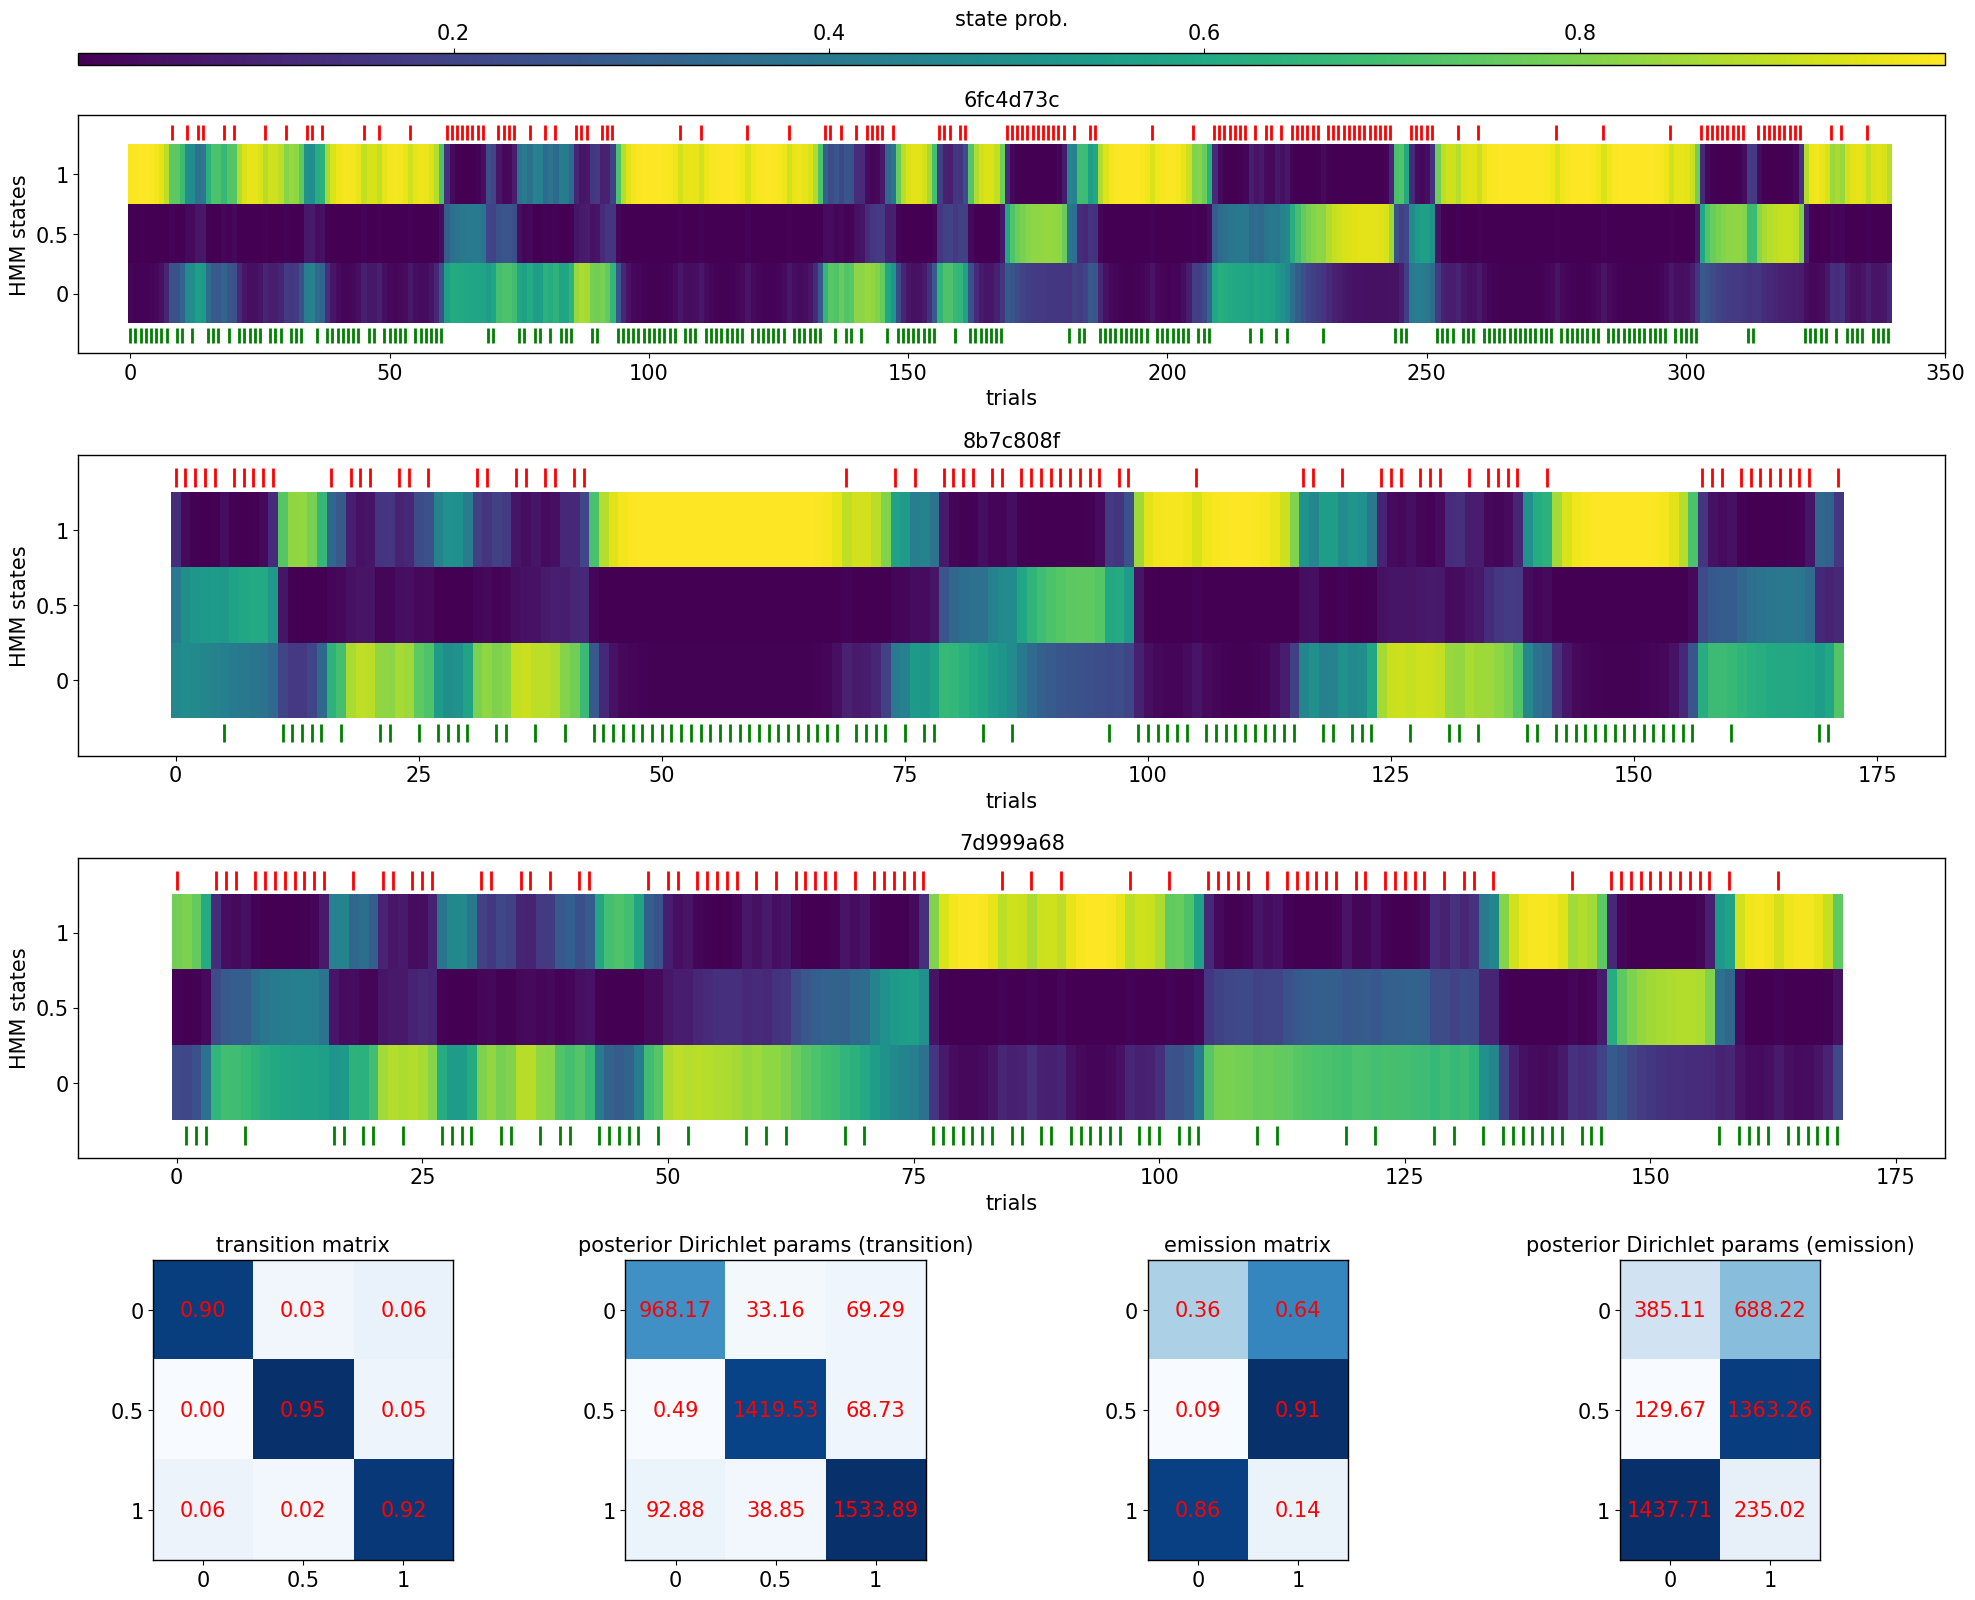

In [6]:
# fit variational hmm 

multi_sess_hmm = vhmm.VariationalCategoricalHMM(n_components=3)
multi_sess_hmm.fit(aligned_train_ys, lengths)

aligned_train_states = multi_sess_hmm.predict_proba(aligned_train_ys)
multi_sess_trial_idxs = np.cumsum([0] + lengths)

train_states = [
    aligned_train_states[multi_sess_trial_idxs[i-1]:multi_sess_trial_idxs[i]] for i in range(1, len(multi_sess_trial_idxs))
]

a_constraint = multi_sess_hmm.transmat_
b_constraint = multi_sess_hmm.emissionprob_
pi_posterior = multi_sess_hmm.startprob_posterior_
a_posterior = multi_sess_hmm.transmat_posterior_
b_posterior = multi_sess_hmm.emissionprob_posterior_

# manually check quality of vhmm fit
plot_multi_session_hmm_results(
    states=train_states,
    choices=train_ys,
    pids=np.array(pids)[train_pid_idxs],
    params=(a_constraint, b_constraint, a_posterior, b_posterior)
)

In [7]:
# fit bmm 

train_ds_flat = np.vstack(train_ds).squeeze()
train_ys_flat = np.vstack(train_ys).squeeze()

with pm.Model() as beta_model:
    eta = pm.Gamma("eta", alpha = 5, beta = 1, shape = 2)
    nu = pm.Gamma("nu", alpha = 1, beta = 5, shape = 2)
    # pymc uses rate lambda but scipy uses scale=1/lambda
    alpha = pm.Exponential("a", eta, shape = 2)
    beta = pm.Exponential("b", nu, shape = 2)
    dk = BetaProcess('d', train_ys_flat, alpha, beta, observed=train_ds_flat)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d", "eta", "nu"], random_seed=seed
    )

a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
a0_prior, a1_prior = beta_ppc["eta"].mean(0)
b0_prior, b1_prior = beta_ppc["nu"].mean(0)
print([a0, b0, a1, b1])
print([a0_prior, b0_prior, a1_prior, b1_prior])

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, nu, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


[0.5387955132383635, 0.6462764818401006, 0.7005238537551982, 0.43323589618293734]
[3.895569803446164, 0.35619516357253567, 3.5439553504403056, 0.3722969005333371]


In [8]:
# initialize bmm-hmm

startprob = multi_sess_hmm.startprob_
pi_prior = multi_sess_hmm.startprob_posterior_
a_prior = multi_sess_hmm.transmat_posterior_
phi_prior = multi_sess_hmm.emissionprob_posterior_

states = [0, 1, 2]
init_pi = {0: np.log(startprob[0]), 1:np.log(startprob[1]), 2: np.log(startprob[2])}
init_a = {
        0: {0: np.log(a_constraint[0][0]), 1: np.log(a_constraint[0][1]), 2: np.log(a_constraint[0][2])},
        1: {0: np.log(a_constraint[1][0]), 1: np.log(a_constraint[1][1]), 2: np.log(a_constraint[1][2])},
        2: {0: np.log(a_constraint[2][0]), 1: np.log(a_constraint[2][1]), 2: np.log(a_constraint[2][2])} }
init_phi = {
        0: {0: np.log(b_constraint[0][0]), 1: np.log(b_constraint[0][1])},
        1: {0: np.log(b_constraint[1][0]), 1: np.log(b_constraint[1][1])},
        2: {0: np.log(b_constraint[2][0]), 1: np.log(b_constraint[2][1])}
         }
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

beta_a_prior = [a1_prior, a0_prior]
beta_b_prior = [b1_prior, b0_prior]

In [9]:
# fit bmm-hmm
bmm_hmm = Constrained_BMM_HMM(
    d, 
    init_pi, 
    init_a, 
    init_phi, 
    init_beta_a, 
    init_beta_b, 
    pi_prior, 
    a_prior, 
    phi_prior,
    beta_a_prior, 
    beta_b_prior,
    tol=1e-1
)
bmm_hmm.update(d)

BMM Convergence Achieved:  True
log-likelihood: 290.69634613722894
BMM Convergence Achieved:  True
log-likelihood: 308.61123632578006
BMM Convergence Achieved:  True
log-likelihood: 309.4668180170178
BMM Convergence Achieved:  True
log-likelihood: 310.05972072332156
BMM Convergence Achieved:  True
log-likelihood: 310.24762306724597
BMM Convergence Achieved:  True
log-likelihood: 310.50776961156686
BMM Convergence Achieved:  True
log-likelihood: 313.6565531519225
BMM Convergence Achieved:  True
log-likelihood: 313.91522276351805
BMM Convergence Achieved:  True
log-likelihood: 313.92439463285297


In [10]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [11]:
# inference

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
post_preds, post_probs = posterior_inference(bmm_hmm, d)

save_metrics.update({
    "acc": {
        "baseline": accuracy_score(y, [1 if d_k > .5 else 0 for d_k in d]),
        "bmmhmm": accuracy_score(y, post_preds)
    }
})
save_metrics.update({
    "auc": {
        "baseline": roc_auc_score(y, d),
        "bmmhmm": roc_auc_score(y, post_probs)
    }
})
save_metrics.update({
    "corr": {
      "baseline": pointbiserialr(y, d)[0],
      "bmmhmm": pointbiserialr(y, post_probs)[0]
    },
})
np.save(save_path["constrained_bmm_hmm_metrics"] / f"{brain_region}.npy", save_metrics)

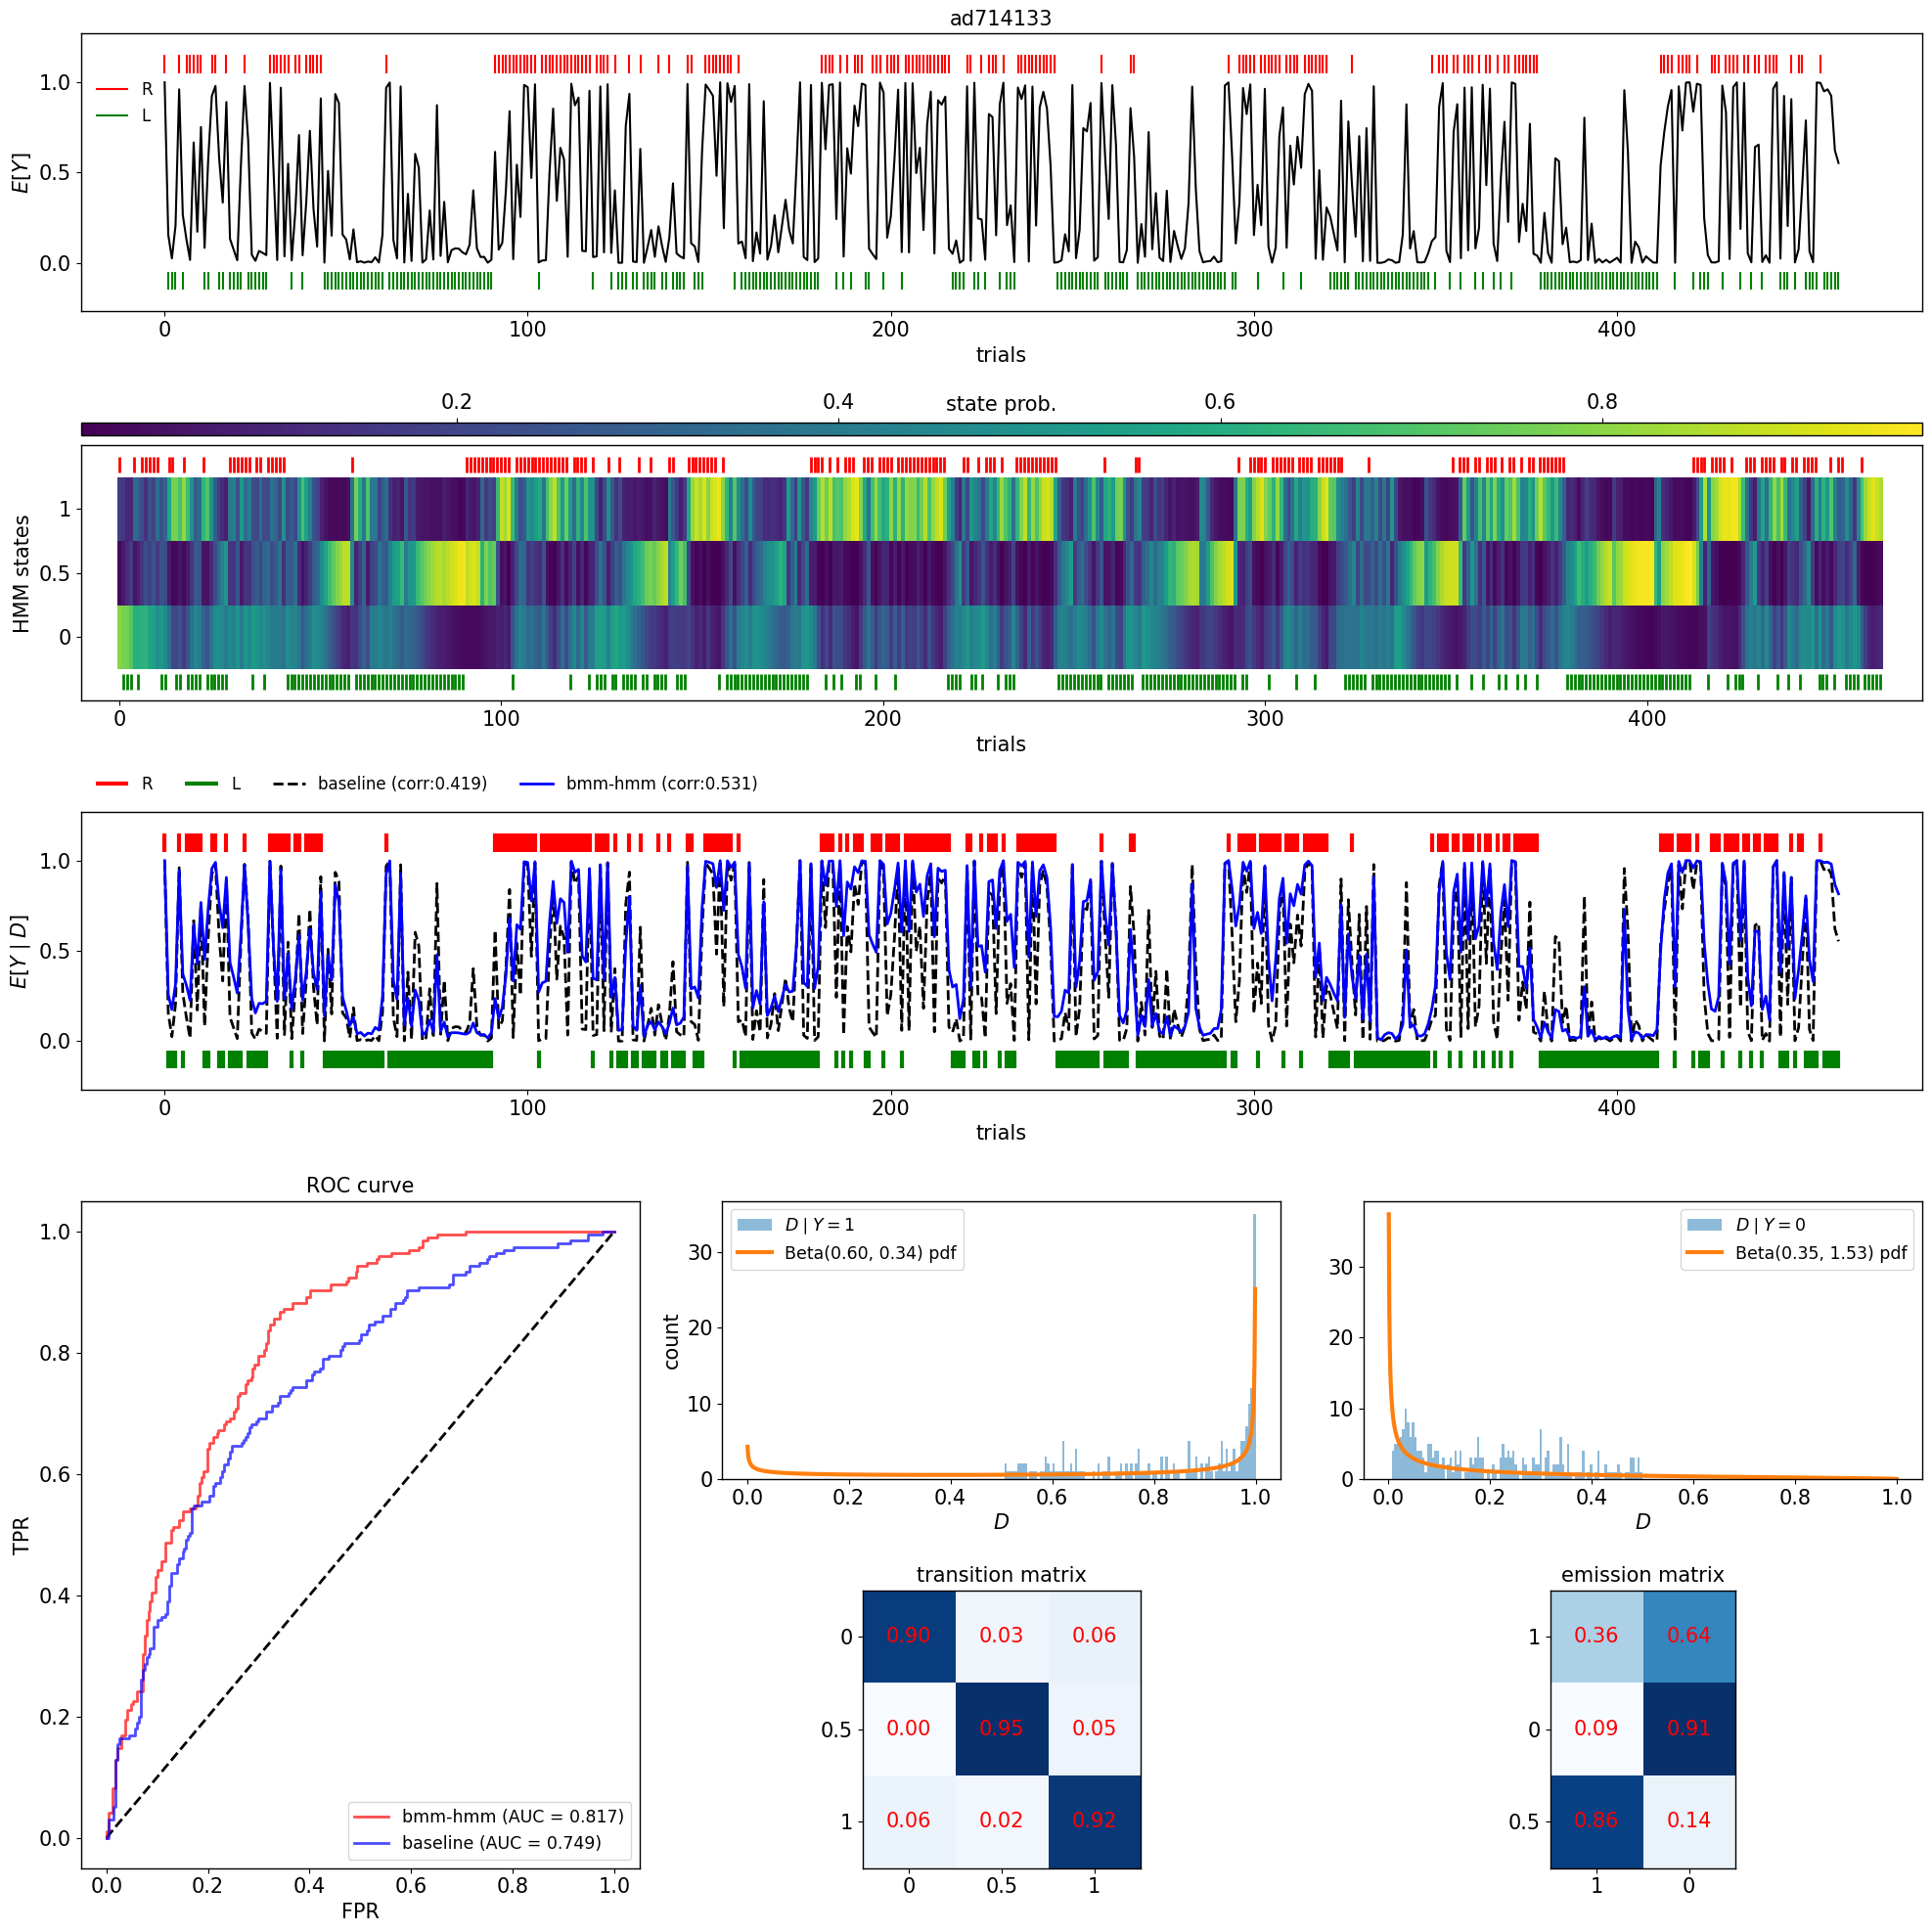

In [12]:
plot_bmm_hmm_results(
    estimates=d,
    post_preds=post_preds,
    post_probs=post_probs,
    states=states,
    choices=y,
    params=(A, B, beta_a_hat, beta_b_hat),
    save_metrics=save_metrics,
    pid=pid,
    brain_region=brain_region
)